# Video Game Sales Analysis – Project Context

This notebook analyzes historical video game sales from the online store Ice, including user and critic reviews, genres, platforms, and ESRB ratings. The objective is to identify the factors that influence whether a game becomes successful.

We assume the perspective of December 2016 and aim to build insights that will support planning the 2017 marketing campaign. The dataset includes information such as game titles, release years, platforms, regional sales (NA, EU, JP), and ESRB age classifications.

The analysis includes:

- Data preprocessing and cleaning
- Exploratory data analysis
- Sales trends by region, platform, and genre
- Evaluation of ESRB rating impact
- Hypothesis testing
- Final recommendation

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
games = pd.read_csv('games.csv')
games.columns = games.columns.str.lower()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
# year of release
games['year_of_release'] = pd.to_numeric(games['year_of_release'], errors='coerce').astype('Int64')

# user score
games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

# critic score
games['critic_score'] = pd.to_numeric(games['critic_score'], errors='coerce')

# rating,  genre y platform

games['rating'] = games['rating'].astype('category')
games['genre'] = games['genre'].astype('category')
games['platform'] = games['platform'].astype('category')


print(games.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


In [4]:
# null values
games = games.dropna(subset=['name'])
games = games.dropna(subset=['year_of_release'])
games = games.dropna(subset=['genre'])
games['rating'] = games['rating'].cat.add_categories('unknown').fillna('unknown')
games['total_sales'] = (
    games['na_sales'] +
    games['eu_sales'] +
    games['jp_sales'] +
    games['other_sales']
)

In the games DataFrame, missing values in name and year_of_release were removed, and the categorical variables (platform, genre, rating) were converted to the category data type. When genre or rating values were missing, they were replaced with "unknown". The numerical sales columns (na_sales, eu_sales, jp_sales, other_sales) were kept as floats, and a new column, total_sales, was created to represent global sales. Finally, the critic and user score fields (critic_score, user_score) were converted to numeric values, preserving nulls when no reviews were available.

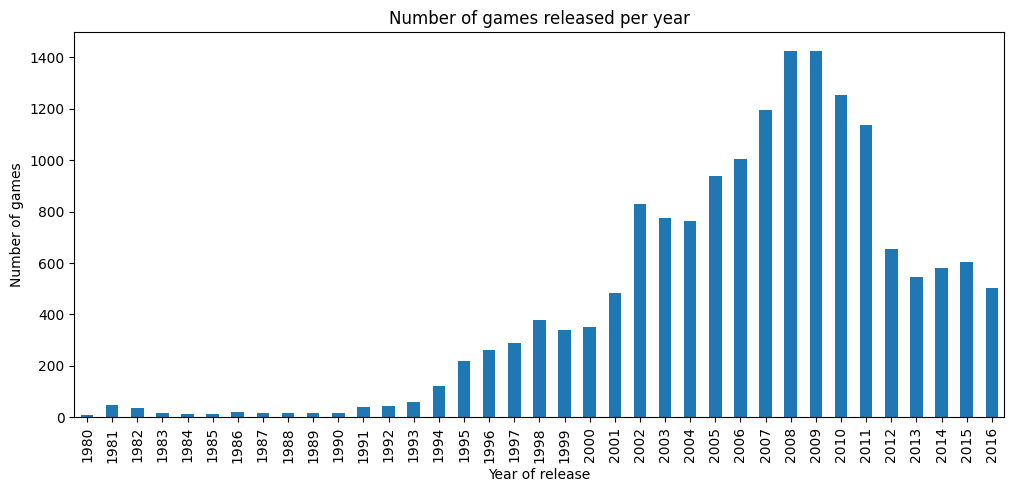

In [5]:
# Count the number of games released per year
games_per_year = games.groupby('year_of_release')['name'].count()

# Plot the results
plt.figure(figsize=(12,5))
games_per_year.plot(kind='bar')
plt.title("Number of games released per year")
plt.xlabel("Year of release")
plt.ylabel("Number of games")
plt.show()



Between 2007 and 2010, the number of games sold increased significantly.

C:\Users\lguti\AppData\Local\Temp\ipykernel_8604\1649459036.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  platform_sales = games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
C:\Users\lguti\AppData\Local\Temp\ipykernel_8604\1649459036.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['year_of_release','platform'])['total_sales']


platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: total_sales, dtype: float64


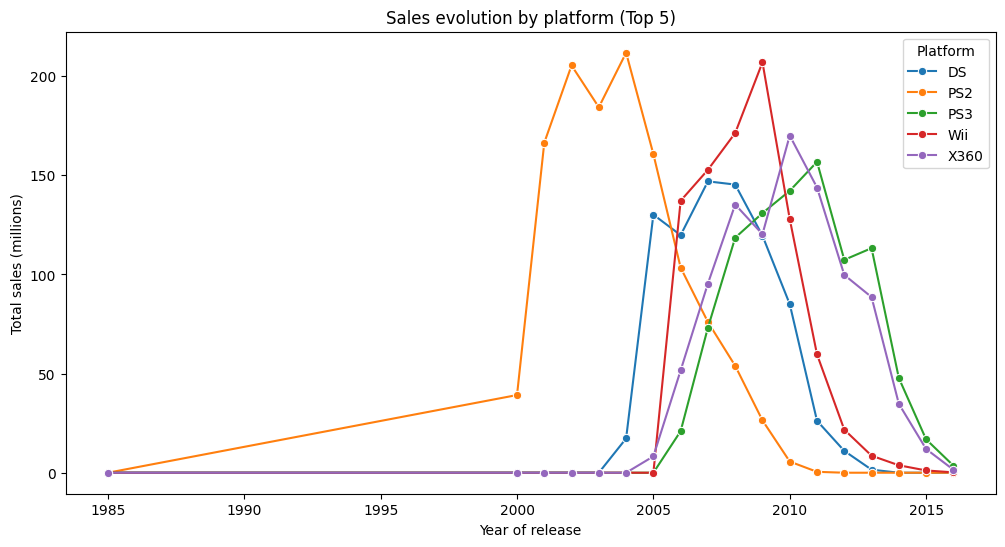

In [6]:
# Calculate total sales per platform and sort in descending order
platform_sales = games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
print(platform_sales.head(10))

# Select the top 5 platforms
top_platforms = platform_sales.head(5).index

# Filter dataset to include only the top platforms
platform_year_sales = (
    games[games['platform'].isin(top_platforms)]
    .copy()
)

# Remove unused categories from the 'platform' column
platform_year_sales['platform'] = platform_year_sales['platform'].cat.remove_unused_categories()

# Group by year and platform, summing total sales
platform_year_sales = (
    platform_year_sales
    .groupby(['year_of_release','platform'])['total_sales']
    .sum()
    .reset_index()
)

# Plot the sales trends for top platforms over time
plt.figure(figsize=(12,6))
sns.lineplot(
    data=platform_year_sales,
    x='year_of_release',
    y='total_sales',
    hue='platform',
    marker="o"
)

plt.title("Sales evolution by platform (Top 5)")
plt.xlabel("Year of release")
plt.ylabel("Total sales (millions)")
plt.legend(title="Platform", loc="upper right")
plt.show()



These are the most popular platforms; however, their sales have declined substantially over time. Their strongest years were between 2005 and 2012, but the release of newer-generation platforms caused their sales to drop sharply.

In [7]:
# Filter games released between 2013 and 2016
recent = games.query("year_of_release >= 2013 and year_of_release <= 2016").copy()

# Calculate total sales per platform (2013–2016)
leaders = (recent.groupby('platform')['total_sales']
           .sum().sort_values(ascending=False))
print(leaders)

# Calculate sales trend per platform: slope >0 indicates growth, <0 indicates decline
trend = (recent.groupby(['platform','year_of_release'])['total_sales'].sum()
         .reset_index())

# Function to calculate slope of sales over years
def slope(g):
    x = g['year_of_release'].values
    y = g['total_sales'].values
    m = np.polyfit(x, y, 1)[0]  # Linear regression to get slope
    return m

# Compute slope for each platform to identify growth or decline
growth = (trend.groupby('platform')
          .apply(slope).sort_values(ascending=False)
          .rename('slope')).to_frame()

print(growth.head(10))  # Platforms with highest growth
print(growth.tail(10))  # Platforms with largest decline


platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
WiiU     64.63
PC       39.43
PSV      32.99
Wii      13.66
PSP       3.50
DS        1.54
3DO       0.00
DC        0.00
GB        0.00
2600      0.00
PCFX      0.00
NG        0.00
NES       0.00
N64       0.00
GEN       0.00
GG        0.00
GC        0.00
GBA       0.00
SCD       0.00
SAT       0.00
PS2       0.00
PS        0.00
WS        0.00
TG16      0.00
SNES      0.00
XB        0.00
Name: total_sales, dtype: float64
           slope
platform        
PS4       14.868
XOne       2.764
2600       0.000
GBA        0.000
GB         0.000
3DO        0.000
DC         0.000
NES        0.000
NG         0.000
GG         0.000
           slope
platform        
SCD        0.000
DS        -0.462
PSP       -0.954
PSV       -2.467
PC        -2.615
Wii       -2.784
WiiU      -5.683
3DS      -14.027
X360     -28.396
PS3      -35.989


C:\Users\lguti\AppData\Local\Temp\ipykernel_8604\4144089457.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  leaders = (recent.groupby('platform')['total_sales']
C:\Users\lguti\AppData\Local\Temp\ipykernel_8604\4144089457.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trend = (recent.groupby(['platform','year_of_release'])['total_sales'].sum()
C:\Users\lguti\AppData\Local\Temp\ipykernel_8604\4144089457.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

C:\Users\lguti\AppData\Local\Temp\ipykernel_25904\2532553890.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_platforms = (recent.groupby('platform')['total_sales']


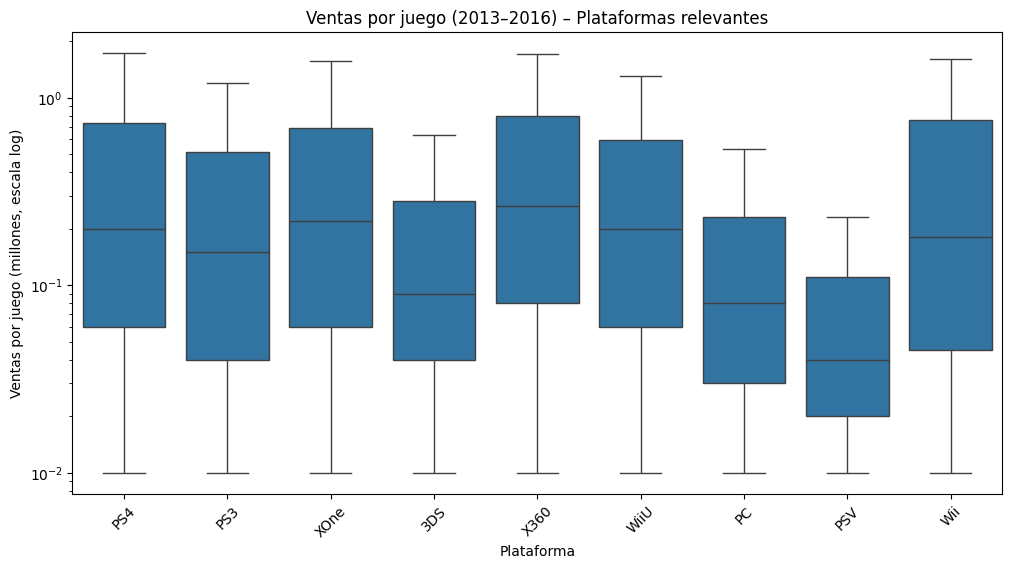

In [20]:
# Filtrar plataformas con ventas totales > 10 millones
valid_platforms = (recent.groupby('platform')['total_sales']
                   .sum()
                   .loc[lambda s: s > 10])  # umbral ajustable

# Ordenar de mayor a menor
order = valid_platforms.sort_values(ascending=False).index

# Boxplot solo de esas plataformas



plt.figure(figsize=(12,6))
sns.boxplot(data=recent[recent['platform'].isin(order)],
            x='platform', y='total_sales',
            order=order, showfliers=False)
plt.yscale('log')
plt.title('Ventas por juego (2013–2016) – Plataformas relevantes')
plt.xlabel('Plataforma'); plt.ylabel('Ventas por juego (millones, escala log)')
plt.xticks(rotation=45)
plt.show()


In recent years, and to obtain a more accurate prediction for 2017, the best-selling platforms were PS4, X360, XOne, and Wii, all showing similar average sales. Below them were WiiU, PS3, and 3DS. Finally, PC ranked second to last, and PSV was the least-selling console among the major platforms.

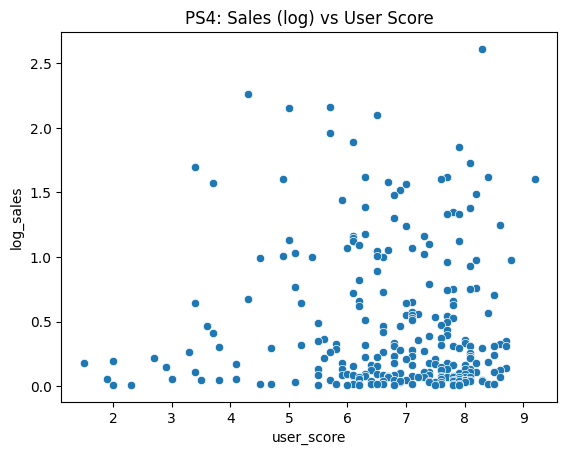

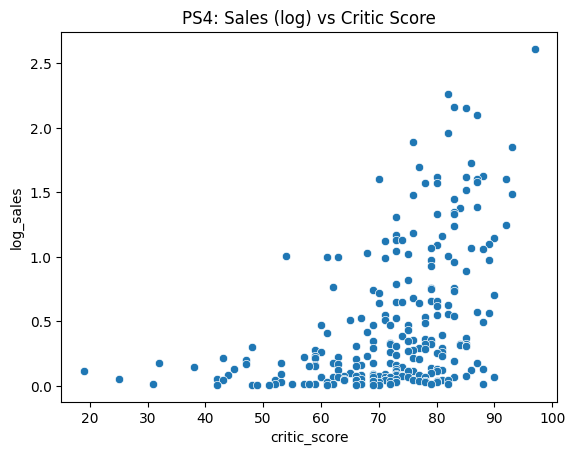

PS4 correlation: user–sales(log)= -0.021  | critic–sales(log)= 0.463


In [8]:
# Filter PS4 games from the recent dataset
ps4 = recent[recent['platform']=='PS4'].copy()

# Apply log1p transformation to reduce skewness in total sales
ps4['log_sales'] = np.log1p(ps4['total_sales'])

# Plot log-transformed sales vs user score
ax = sns.scatterplot(data=ps4, x='user_score', y='log_sales')
ax.set_title('PS4: Sales (log) vs User Score')
plt.show()

# Plot log-transformed sales vs critic score
ax = sns.scatterplot(data=ps4, x='critic_score', y='log_sales')
ax.set_title('PS4: Sales (log) vs Critic Score')
plt.show()

# Calculate Pearson correlation between scores and log sales
corr_user = ps4[['user_score','log_sales']].corr(method='pearson').iloc[0,1]
corr_crit = ps4[['critic_score','log_sales']].corr(method='pearson').iloc[0,1]

print('PS4 correlation: user–sales(log)=', round(corr_user,3),
      ' | critic–sales(log)=', round(corr_crit,3))



User Score vs. Sales (log): –0.021 → This indicates virtually no relationship. User reviews do not predict PS4 sales.

Critic Score vs. Sales (log): 0.463 → This indicates a moderate positive correlation. Higher critic ratings tend to be associated with higher sales.

C:\Users\lguti\AppData\Local\Temp\ipykernel_8604\2511124318.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index='name', columns='platform', values='total_sales', aggfunc='sum')


PS4 vs XOne and PS4 vs PC comparison (sales in millions):

platform  PS4_minus_XOne  PS4_minus_PC
count         473.000000    473.000000
mean            0.305201      0.533573
std             0.812459      1.378178
min            -2.950000     -0.830000
25%             0.000000      0.000000
50%             0.050000      0.060000
75%             0.250000      0.400000
max             7.240000     14.370000


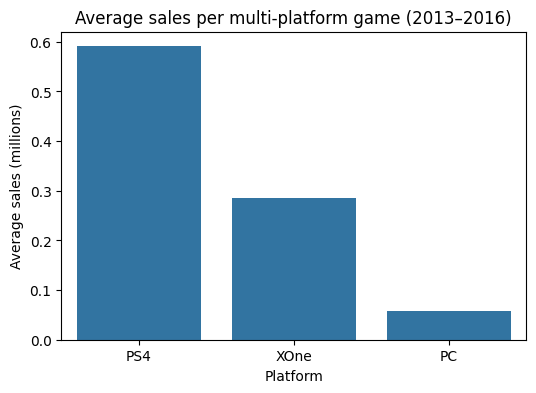

In [9]:
# Multi-platform games (2013–2016) and how their sales vary

# Step 1: Identify games released on more than one platform
multi = (recent.groupby('name')['platform'].nunique()
         .rename('nplat')).reset_index()
multi_names = multi.loc[multi['nplat'] > 1, 'name']

# Step 2: Create a table of sales per game and platform
cross = (recent[recent['name'].isin(multi_names)]
         .pivot_table(index='name', columns='platform', values='total_sales', aggfunc='sum')
         .fillna(0)
         .copy())

# Step 3: Ensure columns are not categorical
cross.columns = cross.columns.astype(str)

# Step 4: Calculate sales differences (example comparisons)
cross['PS4_minus_XOne'] = cross.get('PS4', 0) - cross.get('XOne', 0)
cross['PS4_minus_PC']   = cross.get('PS4', 0) - cross.get('PC', 0)

# Step 5: Statistical summary of differences
print("PS4 vs XOne and PS4 vs PC comparison (sales in millions):\n")
print(cross[['PS4_minus_XOne', 'PS4_minus_PC']].describe())

# Step 6: Visualization – average sales per platform
avg_sales = cross[['PS4','XOne','PC']].mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=avg_sales.index, y=avg_sales.values)
plt.title("Average sales per multi-platform game (2013–2016)")
plt.ylabel("Average sales (millions)")
plt.xlabel("Platform")
plt.show()


C:\Users\lguti\AppData\Local\Temp\ipykernel_25904\1474628353.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_sales  = (recent.groupby('genre')['total_sales'].sum()
C:\Users\lguti\AppData\Local\Temp\ipykernel_25904\1474628353.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_median = (recent.groupby('genre')['total_sales'].median()


Top géneros por total de ventas:
 genre
Action          321.87
Shooter         232.98
Sports          150.65
Role-Playing    145.89
Misc             62.82
Platform         42.63
Racing           39.89
Fighting         35.31
Adventure        23.64
Simulation       21.76
Name: total_sales, dtype: float64
Top géneros por mediana de ventas por juego:
 genre
Shooter         0.450
Sports          0.240
Platform        0.225
Role-Playing    0.125
Fighting        0.125
Racing          0.120
Action          0.110
Simulation      0.100
Misc            0.100
Strategy        0.080
Name: total_sales, dtype: float64


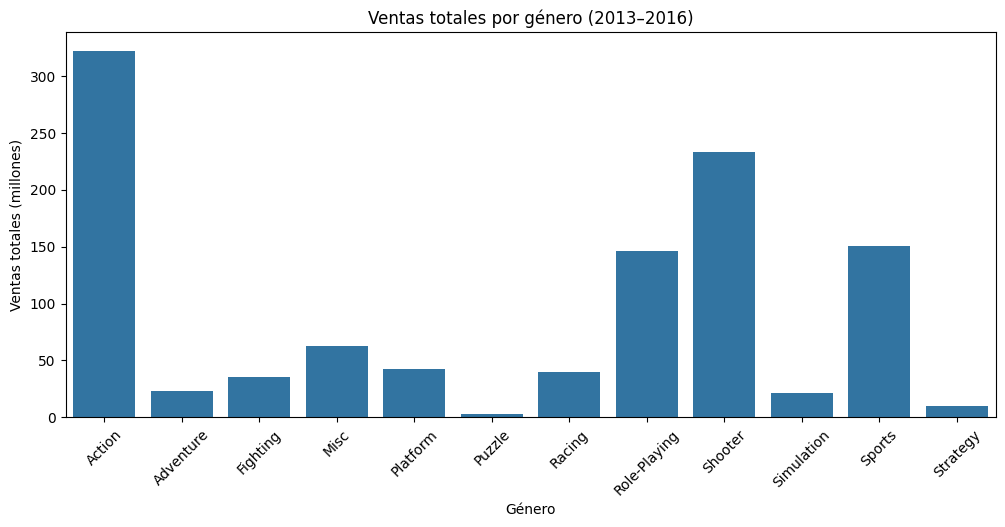

In [23]:
genre_counts = recent['genre'].value_counts()
genre_sales  = (recent.groupby('genre')['total_sales'].sum()
                .sort_values(ascending=False))
genre_median = (recent.groupby('genre')['total_sales'].median()
                .sort_values(ascending=False))

print('Top géneros por total de ventas:\n', genre_sales.head(10))
print('Top géneros por mediana de ventas por juego:\n', genre_median.head(10))

plt.figure(figsize=(12,5))
sns.barplot(x=genre_sales.index, y=genre_sales.values)
plt.xticks(rotation=45); plt.title('Ventas totales por género (2013–2016)')
plt.ylabel('Ventas totales (millones)'); plt.xlabel('Género'); plt.show()


A clear difference can be observed between the Action, Shooter, Role-Playing, and Sports genres compared to the rest. These four dominate the market, with Action being the top-selling genre—approximately twice as large as Sports, which ranks third in total sales.

C:\Users\lguti\AppData\Local\Temp\ipykernel_8604\4261409988.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top = (games.groupby('platform')[region].sum()
C:\Users\lguti\AppData\Local\Temp\ipykernel_8604\4261409988.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top = (games.groupby('genre')[region].sum()
C:\Users\lguti\AppData\Local\Temp\ipykernel_8604\4261409988.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warnin


Top 5 platforms in NA_SALES:
 platform
X360    595.74
PS2     572.92
Wii     486.87
PS3     390.13
DS      380.31
Name: na_sales, dtype: float64

Top 5 platforms in EU_SALES:
 platform
PS2     332.63
PS3     327.21
X360    268.32
Wii     258.32
PS      212.39
Name: eu_sales, dtype: float64

Top 5 platforms in JP_SALES:
 platform
DS      175.02
PS      139.78
PS2     137.54
SNES    116.55
3DS     100.62
Name: jp_sales, dtype: float64

Top 5 genres in NA_SALES:
 genre
Action      863.17
Sports      671.20
Shooter     584.83
Platform    444.44
Misc        399.57
Name: na_sales, dtype: float64

Top 5 genres in EU_SALES:
 genre
Action     510.99
Sports     371.33
Shooter    314.52
Racing     234.49
Misc       210.60
Name: eu_sales, dtype: float64

Top 5 genres in JP_SALES:
 genre
Role-Playing    353.39
Action          160.14
Sports          134.93
Platform        130.71
Misc            107.02
Name: jp_sales, dtype: float64

ESRB ratings sales (NA, EU, JP):
          na_sales  eu_sales  jp_

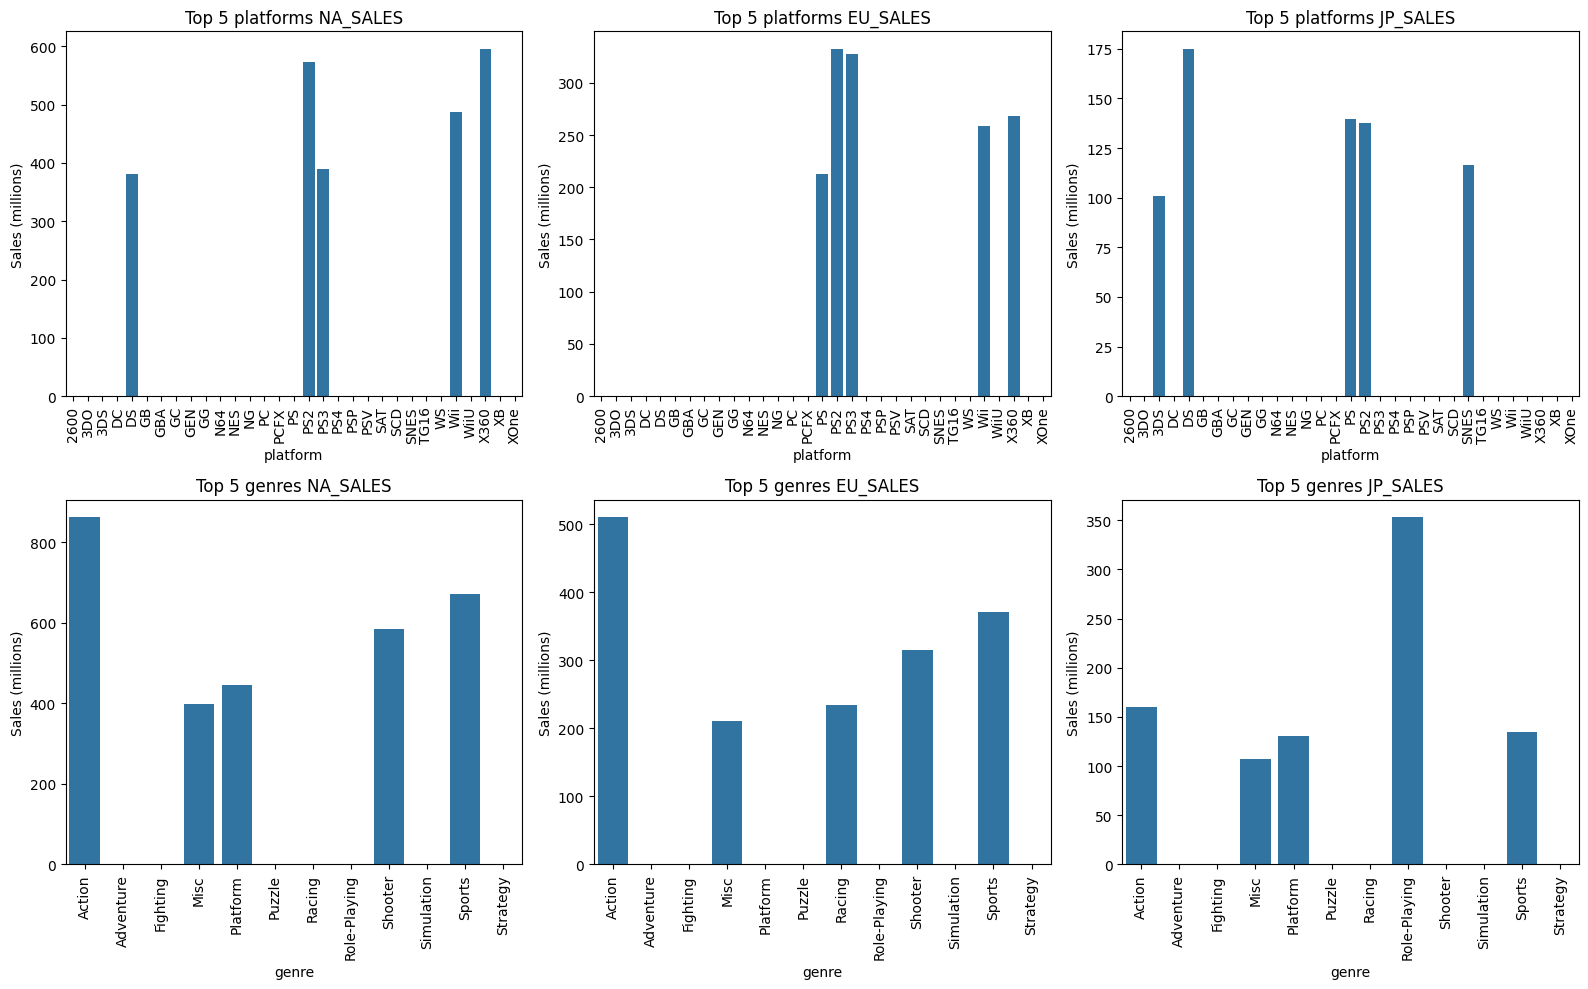

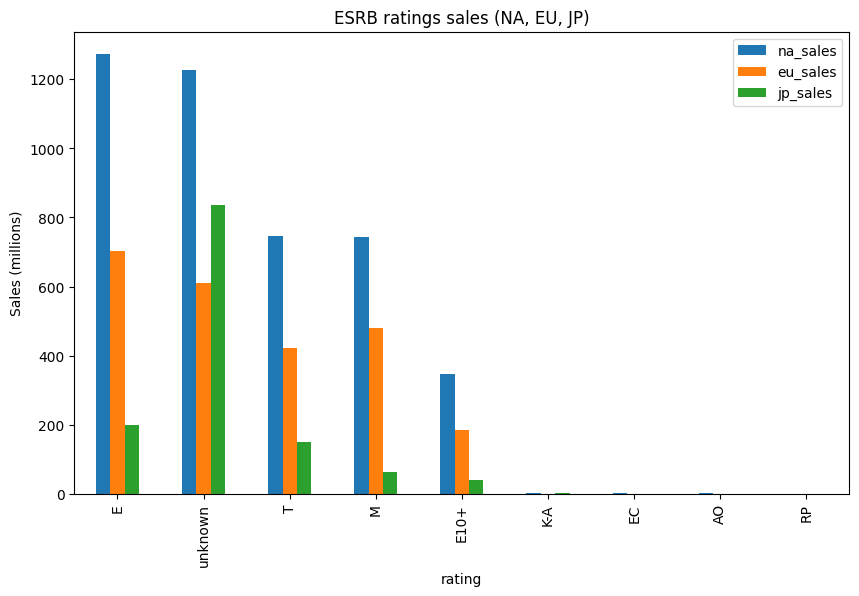

In [11]:
# Step 4

# Top 5 platforms by region
region_cols = ['na_sales', 'eu_sales', 'jp_sales']

top_platforms = {}
for region in region_cols:
    top = (games.groupby('platform')[region].sum()
                  .sort_values(ascending=False)
                  .head(5))
    top_platforms[region] = top
    print(f"\nTop 5 platforms in {region.upper()}:\n", top)

# Top 5 genres by region
top_genres = {}
for region in region_cols:
    top = (games.groupby('genre')[region].sum()
                  .sort_values(ascending=False)
                  .head(5))
    top_genres[region] = top
    print(f"\nTop 5 genres in {region.upper()}:\n", top)

# ESRB ratings sales by region
esrb_sales = (games.groupby('rating')[region_cols]
                   .sum()
                   .sort_values(by='na_sales', ascending=False))
print("\nESRB ratings sales (NA, EU, JP):\n", esrb_sales)

# Plot top platforms and genres by region
fig, axes = plt.subplots(2, 3, figsize=(16,10))

for i, region in enumerate(region_cols):
    # Platforms
    sns.barplot(x=top_platforms[region].index, y=top_platforms[region].values, ax=axes[0,i])
    axes[0,i].set_title(f"Top 5 platforms {region.upper()}")
    axes[0,i].set_ylabel("Sales (millions)")
    axes[0,i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels
    
    # Genres
    sns.barplot(x=top_genres[region].index, y=top_genres[region].values, ax=axes[1,i])
    axes[1,i].set_title(f"Top 5 genres {region.upper()}")
    axes[1,i].set_ylabel("Sales (millions)")
    axes[1,i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

# Plot ESRB ratings sales
esrb_sales.plot(kind='bar', figsize=(10,6))
plt.title("ESRB ratings sales (NA, EU, JP)")
plt.ylabel("Sales (millions)")
plt.show()



Based on the genre-related charts, the following conclusions can be drawn:

Top 5 Platforms:
Across all regions, we can affirm that the PS2 achieved a significant number of units sold. However, the best-selling platforms varied by region: in North America, the top seller was the X360; in Europe, the PS2; and in Japan, the DS.

Top 5 Genres:
We observe a consistent pattern in which the Action genre ranked first in both North America and Europe, and second in Japan, making it the overall leading genre. Two other strong performers across all regions are Sports and Role-Playing.

Sales by ESRB Rating:
All regions displayed a similar pattern, with the E rating achieving the highest sales, followed by T and M respectively. This visualization also highlights the overall dominance of the North American market in terms of total sales.

In [12]:
# Filter user scores, removing null values
xbox_ratings = games.loc[games['platform'] == 'XOne', 'user_score'].dropna()
pc_ratings   = games.loc[games['platform'] == 'PC', 'user_score'].dropna()

action_ratings = games.loc[games['genre'] == 'Action', 'user_score'].dropna()
sports_ratings = games.loc[games['genre'] == 'Sports', 'user_score'].dropna()

# T-test: Xbox One vs PC
t_stat1, p_val1 = stats.ttest_ind(xbox_ratings, pc_ratings, equal_var=False)

# T-test: Action vs Sports
t_stat2, p_val2 = stats.ttest_ind(action_ratings, sports_ratings, equal_var=False)

alpha = 0.05  # Significance level

print("Xbox One vs PC:")
print("t =", t_stat1, " p =", p_val1)
if p_val1 < alpha:
    print("➡ Reject H₀: there is a significant difference in user scores.\n")
else:
    print("➡ Fail to reject H₀: no evidence of a significant difference.\n")

print("Action vs Sports:")
print("t =", t_stat2, " p =", p_val2)
if p_val2 < alpha:
    print("➡ Reject H₀: there is a significant difference in user scores.\n")
else:
    print("➡ Fail to reject H₀: no evidence of a significant difference.\n")



Xbox One vs PC:
t = -4.671113961085972  p = 4.5385802963771835e-06
➡ Reject H₀: there is a significant difference in user scores.

Action vs Sports:
t = 1.789373351094851  p = 0.07370217419278526
➡ Fail to reject H₀: no evidence of a significant difference.



## Conclusions

1. *Sales Trends*

Between 2007 and 2010, there was a notable increase in video game sales, with the overall peak occurring between 2005 and 2012. From that point forward, sales declined significantly due to the emergence of new console generations that displaced older platforms. In more recent years, the platforms with the highest sales levels were PS4, X360, XOne, and Wii, all with relatively similar volumes. Below them were WiiU, PS3, and 3DS, while PC ranked near the bottom—just above PSV, which recorded the lowest sales among the major platforms.

2. *Factors Influencing Sales*

When analyzing the relationship between reviews and sales, the User Score on PS4 showed no predictive power for commercial performance (correlation ≈ –0.021). In contrast, the Critic Score showed a moderate and positive correlation (0.463), suggesting that higher critic ratings are indeed associated with higher sales.

3. *Genre Behavior*
The Action, Shooter, Role-Playing, and Sports genres account for the majority of total sales, with Action being the clear market leader across regions. In North America and Europe, Action ranked first, while in Japan it ranked second but still maintained strong relevance.

4. *Statistical Results*

The hypothesis tests provided deeper insights:

- Xbox One vs. PC: A statistically significant difference was found in average user ratings (p < 0.001), indicating that players’ perceptions differ between these platforms.
- Action vs. Sports: No significant difference was found in average ratings (p ≈ 0.074), meaning there is insufficient evidence to conclude that users value these two genres differently.

5. *Regional Differences*

The regional analysis revealed notable variations. The best-selling console in North America was the X360, in Europe the PS2, and in Japan the DS. Regarding genres, Action led in NA and EU and maintained second place in JP. ESRB rating patterns were consistent across all regions: E (Everyone) was the top-selling category, followed by T (Teen) and M (Mature). Additionally, North America significantly outperformed both Europe and Japan in total consumption volume.